# WIKIVOYAGE EDA

In [1]:
import pandas as pd
import json
from collections import defaultdict
import unicodedata
import mistune
from bs4 import BeautifulSoup
import string
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from sklearn.manifold import MDS
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Load & Extract Articles

In [2]:
with open('../data/wikivoyage.json','rb') as f:
    data = json.loads(f.read())

###Extract Article texts

In [3]:
articles = data['mediawiki']['page']

### Save Articles by Titles

In [4]:
articles_dict = {}
for article in articles:
    # Lets strip the accents using unicodedata
    title = unicodedata.normalize('NFKD', article['title']).encode('ascii','ignore')
    articles_dict[title] = article

In [5]:
articles_dict.keys()[:10]

['',
 'Category:Articles needing style fixes',
 'Szczecin',
 'Category:West High Country',
 'Rugia',
 'New Australia',
 'Natchez, Mississippi',
 'File:WV new main page at 1920px.PNG',
 'Nampa',
 'Category:Pangasinan']

__You can see that some articles are files, categories ,etc with : in their names.  
Lets see how many of these there are.__

In [6]:
junk_articles_dict = defaultdict(int)
for article in articles:
    title = article['title']
    if ':' in title:
        junk_articles_dict[title.split(':')[0]] += 1

print len(junk_articles_dict)
junk_articles_dict

11


defaultdict(<type 'int'>, {u'Category': 4561, u'Itinerary': 1, u'General/Wikivoyage': 1, u'MediaWiki': 142, u'File': 816, u'Poland': 1, u'La Manzanilla': 1, u'Module': 23, u'Wikivoyage': 1561, u'Template': 1043, u'Help': 8})

__There are a lot of special type articles. Let's actually take a look at the content to see if they are useful.__

In [7]:
special_articles_dict = defaultdict(list)
for article in articles:
    title = article['title']
    if ':' in title:
        if len(special_articles_dict[title.split(':')[0]]) < 5:
            special_articles_dict[title.split(':')[0]].append(article) 

print len(special_articles_dict)
special_articles_dict.keys()

11


[u'Category',
 u'Itinerary',
 u'General/Wikivoyage',
 u'MediaWiki',
 u'File',
 u'Poland',
 u'La Manzanilla',
 u'Module',
 u'Wikivoyage',
 u'Template',
 u'Help']

__Let's take a look at two most common special type articles__

In [8]:
special_articles_dict['MediaWiki']

[{u'id': u'69005',
  u'ns': u'8',
  u'revision': {u'comment': u'+arytrekking\\.com',
   u'contributor': {u'id': u'36420', u'username': u'Ikan Kekek'},
   u'format': u'text/x-wiki',
   u'id': u'2796508',
   u'model': u'wikitext',
   u'parentid': u'2781066',
   u'sha1': u'l0bq8j7kgs7ttk8ngewi2h36byn4q61',
   u'text': {u'#text': u'#{{shortcut|[[Spam]]<br>[[Blacklist]]}} \n #{{notice|\'\'\'DO NOT\'\'\' remove any URL or pattern from this list without first gaining consensus on [[{{TALKSPACE}}:{{PAGENAME}}]]. In addition to being used to block automated spam attacks this list is also occasionally used to stop persistent abuse of the [[Project:External links]] and [[Project:Don\'t tout]] policies.  Please add violators of the external links policy to this page \'\'\'ONLY\'\'\' after first trying to educate the user about why the link is inappropriate.  When adding external link violators to this page please explain the reason for the addition on [[{{TALKSPACE}}:{{PAGENAME}}]].}}\n\n # This i

In [9]:
special_articles_dict['Wikivoyage']

[{u'id': u'1539',
  u'ns': u'4',
  u'revision': {u'comment': u'isPartOf',
   u'contributor': {u'id': u'1844', u'username': u'Globe-trotter'},
   u'format': u'text/x-wiki',
   u'id': u'2043579',
   u'minor': None,
   u'model': u'wikitext',
   u'parentid': u'1923444',
   u'sha1': u'q2bedim1zidlfvjh6qy4zo6xf076gon',
   u'text': {u'#text': u'{{joke}}\n\n\'\'\'Arial\'\'\' (Goudy: \'\'Helvetica\'\'), on [[Wikivoyage:Joke articles/Lower Caisse|Lower Caisse]], is a smaller and quieter town than hurly-burly [[Wikivoyage:Joke articles/Bodoni|Bodoni]], but travellers will get a chance to experience the \'\'real\'\' [[Wikivoyage:Joke articles/San Serriffe|San Serriffe]] on a visit to this town.\n\nFounded in the 19th century by a colony of Swiss Utopians fleeing persecution in their own country, Arial has a Nordic look with somewhat more steeply sloped tin roofs to the buildings. The city is worth visiting for its period architecture and its white spaces. \n\n==Get in==\n===By parachute===\nUS nav

__These special articles are not actual travel guide articles so I will create a new dictionary without them.__

In [10]:
# articles without :'s in their titles
articles_dict = {}
for article in articles:
    # Lets strip the accents using unicodedata
    title = unicodedata.normalize('NFKD', article['title']).encode('ascii','ignore')
    if ':' not in title:
        articles_dict[title] = article

print len(articles_dict)
articles_dict[articles_dict.keys()[1]]

42754


{u'id': u'34976',
 u'ns': u'0',
 u'revision': {u'contributor': {u'id': u'244322',
   u'username': u'Double sharp'},
  u'format': u'text/x-wiki',
  u'id': u'2763935',
  u'minor': None,
  u'model': u'wikitext',
  u'parentid': u'2739009',
  u'sha1': u'jfmz1rvkzz1nfe7dqzq0izms4v764dh',
  u'text': {u'#text': u'{{pagebanner|Szczecin Wikivoyage Banner.png}}\n\n\'\'\'[http://www.szczecin.eu/en/ Szczecin]\'\'\', (pronounced \'\'Shchetsin\'\', German: \'\'Stettin\'\', Latin: \'\'Stetinum\'\'; is maritime port city and the capital of [[Zachodniopomorskie]] in [[Poland]]. The city has a population of over 400 000 thousand, with almost 800 000 living its metro area, and is one of the seven largest metropoles in the country. It lies in the northwestern corner of Poland, very close to the German border, and it is in fact easier to get to Szczecin from some parts of Germany, notable from [[Berlin]], than it is from much of the Polish territory. For a significant part of its history, actually, Szczecin

### Now that we have a dictionary of travel guide articles, lets check out the article lenghts.

In [11]:
article_lengths_dict = {}
for key, value in articles_dict.iteritems():
    article_length = len(value['revision']['text']['#text'])
    article_lengths_dict[key] = article_length

article_lengths_dict

{'': 20,
 'Szczecin': 33999,
 'San Juan Islands': 21187,
 'Rugia': 11293,
 'New Australia': 875,
 'Natchez, Mississippi': 21,
 'Nampa': 7084,
 'Jamaica (disambiguation)': 380,
 'Hyanger': 791,
 'Xigatse (prefecture)': 1794,
 'York (Maine)': 19321,
 'Calangute Beach': 23,
 'Fulda': 9523,
 'Novi Sad': 26800,
 'Eure': 28,
 'Moovattupuzha': 26,
 'Gravesend': 1874,
 'Turkmen phrasebook': 3126,
 'Caen': 5997,
 'Madeira Islands': 21,
 'Miami Springs': 896,
 'Houston/East Houston': 4176,
 'Gwangalli': 26,
 'Malabon': 1082,
 'Wind surfing': 24,
 'Hikone': 7609,
 'Pea Ridge': 2272,
 'Airline consolidators': 36,
 'Kearney': 20,
 'Mokhotlong': 1467,
 'Loei': 7551,
 'Loen': 19,
 'Pergamon': 21,
 'Paris/Champs Elysee': 38,
 'Central Limburg (Belgium)': 31,
 'Rio de janerio': 28,
 'South Uist': 9641,
 'Cahir': 1378,
 'Volta Delta': 563,
 'Jeffersonville': 703,
 'Indian Harbour Beach (Florida)': 34,
 'Orcas Village': 7316,
 'Scituate (Rhode Island)': 12021,
 'Western Nevada': 7920,
 'Pampa': 12355,
 "

__Check out some articles with short lengths__

In [12]:
articles_dict['Berneray (disambiguation)']

{u'id': u'3554',
 u'ns': u'0',
 u'revision': {u'comment': u'/* United Kingdom */ Add Great Bernera',
  u'contributor': {u'id': u'1812', u'username': u'AlasdairW'},
  u'format': u'text/x-wiki',
  u'id': u'2592780',
  u'model': u'wikitext',
  u'parentid': u'2381967',
  u'sha1': u'bz5yrk7qxjzi4c711uuyt1lmwgfk9u5',
  u'text': {u'#text': u"{{pagebanner|Disambiguation banner.png|pgname=Berneray}}\nThere's more than one place called '''Berneray''':\n\n=== [[United Kingdom]] ===\n\n* [[Berneray]] (Bhe\xe0rnaraidh) - one of two inhabited islands in the Sound of Harris, to the north of [[North Uist]] in the [[Outer Hebrides]], [[Scotland]]\n\n* [[Berneray (Barra Head)]] - an uninhabited island, and the southernmost part of the [[Outer Hebrides]], [[Scotland]]\n\n* [[Great Bernera]] - is in an island off the northwest coast of [[Lewis]] in the [[Outer Hebrides]]. \n\n[[WikiPedia:Berneray]]\n\n{{disamb}}",
   u'@xml:space': u'preserve'},
  u'timestamp': u'2014-05-25T16:33:55Z'},
 u'title': u'Berne

In [13]:
df_article_lengths = pd.DataFrame(article_lengths_dict.items(), columns = ['title', 'length'])

__Plot histogram to see the distribution of articles by length.__

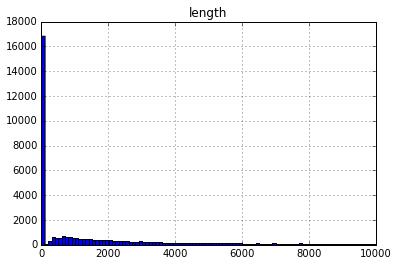

In [14]:
condition1 = df_article_lengths['length'] < 10000
df_article_lengths[condition1].hist(bins=100);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff86e50>]], dtype=object)

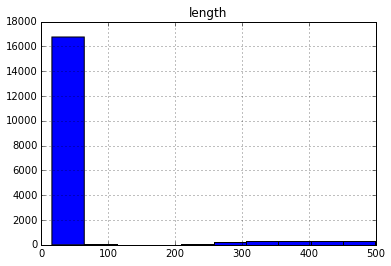

In [15]:
### STUDY HOW MANY CHARS ARTICLES HAVE.
condition2 = df_article_lengths['length'] < 500
df_article_lengths[condition2].hist(bins=10)

## IT CAN BE SEEN THAT THERE ARE ABOUT 17,000 ARTICLES LESS THAN 200 CHARACTERS.
## ARTICLES WITH LESS THAN 200 WORDS WOULD MEAN THEY DON'T HAVE GOOD DESTINATION DESCRIPTONS OR ARE AMBIGUOUS DESTINATIONS, MEANING THEY AREN'T
## POPULAR DESTINATIONS.

In [16]:
condition3 = df_article_lengths['length'] < 200
df_article_200_char_plus = df_article_lengths[-condition3]

In [17]:
final_titles = df_article_200_char_plus['title']

In [18]:
final_titles.head(10)

1                     Szczecin
2             San Juan Islands
3                        Rugia
4                New Australia
6                        Nampa
7     Jamaica (disambiguation)
8                      Hyanger
9         Xigatse (prefecture)
10                York (Maine)
12                       Fulda
Name: title, dtype: object

In [19]:
# Create dictionary of titles that have concatenated names as the values. For example: San Francisco: San_Francisco
def clean_final_titles(titles):
    final_titles_concat = {}
    for title in titles:
        if '(disambiguation)' not in title:
            key = title
            value = title.replace(' (', ',')
            value = value.replace(')', '')
            value = value.replace(' ','_')
            final_titles_concat[key] = value
    return final_titles_concat

In [20]:
final_titles_concat = clean_final_titles(final_titles)
final_titles_concat

{'Szczecin': 'Szczecin',
 'Rugia': 'Rugia',
 'New Australia': 'New_Australia',
 'Nampa': 'Nampa',
 'Hyanger': 'Hyanger',
 'Xigatse (prefecture)': 'Xigatse,prefecture',
 'York (Maine)': 'York,Maine',
 'Fulda': 'Fulda',
 'Novi Sad': 'Novi_Sad',
 'Gravesend': 'Gravesend',
 'Turkmen phrasebook': 'Turkmen_phrasebook',
 'Caen': 'Caen',
 'Miami Springs': 'Miami_Springs',
 'Houston/East Houston': 'Houston/East_Houston',
 'Malabon': 'Malabon',
 'Hikone': 'Hikone',
 'Pea Ridge': 'Pea_Ridge',
 'Diest': 'Diest',
 'Goshen': 'Goshen',
 'Loei': 'Loei',
 'Saco': 'Saco',
 'South Uist': 'South_Uist',
 'Cahir': 'Cahir',
 'Volta Delta': 'Volta_Delta',
 'Jeffersonville': 'Jeffersonville',
 'Orcas Village': 'Orcas_Village',
 'Scituate (Rhode Island)': 'Scituate,Rhode_Island',
 'Western Nevada': 'Western_Nevada',
 'Pampa': 'Pampa',
 'Gangtok': 'Gangtok',
 'Bali (Crete)': 'Bali,Crete',
 'Oqaatsut': 'Oqaatsut',
 'Montreal/Parc Jean-Drapeau': 'Montreal/Parc_Jean-Drapeau',
 'Itapecerica da Serra': 'Itapecerica_d

__There are still disambiguation articles which don't add much information so lets get rid of them.__

In [21]:
final_articles = {}
for title in final_titles_concat.iterkeys():
    concat_title = final_titles_concat[title]
    final_articles[concat_title] = unicodedata.normalize('NFKD', articles_dict[title]['revision']['text']['#text']).encode('ascii','ignore')
final_articles
print len(final_articles)

25495


In [22]:
#final_articles['Paris']

In [23]:
def clean_paragraph(string):
    # get rid of https:
    m = re.sub(r'(https?://\S+\ +\S+)', '', string)
    # get rid of [File:stuff]
    m = re.sub(r'\[File:[^)]*\]','', m)
    # get rid of ==stuff==
    m = re.sub(r'(\=+[^)]+\=+)','', m)
    #get rid of ], [, '. E.g. [[Paris]] --> Paris
    m = re.sub(r'[\[\]\']','',unicodedata.normalize('NFKD', m).encode('ascii','ignore')).strip()

    return m

In [24]:
def clean_sentence(string):
    # punctuation and numbers to be removed
    punctuation1 = re.compile(r'[*.?!,"0-9]')
    punctuation2 = re.compile(r'[-:;()|]')
    sent = re.sub(punctuation1,'', string)
    sent = re.sub(punctuation2, ' ', sent)
    return sent

In [25]:
clean_sentence('seoul-incheon internatio*nal)')

'seoul incheon international '

In [26]:
def convert_article_into_list_of_words(article):
    md = mistune.markdown(article)
    parsed_md = BeautifulSoup(md, 'html.parser')
    
    parsed_test_wo_dict = []
    
    #Grab all the paragraphs and lists
    for line in parsed_md.find_all(['p','li']):
        text = line.text
        
        #remove dictionaries by filtering on {{
        if '{{' not in text:
            #clean the paragraph by removing things like https:stuff, File:stuff
            text = clean_paragraph(text)
            
            #tokenize paragraph to sentences
            sentences = sent_tokenize(text)
            
            for sentence in sentences:
                #clean sentence by removing numbers and punctuations
                sent = clean_sentence(sentence)
                #convert sentence to list of words
                word_list = sent.split()
                #keep the sentence if there are more than 3 words.
                if len(word_list) > 3:
                    parsed_test_wo_dict.append(word_list)
    return parsed_test_wo_dict

In [27]:
final_articles.keys()

['Albion,California',
 'Szczecin',
 'Bowling_Green,Kentucky',
 'Rugia',
 'Nampa',
 'Hyanger',
 'Fazenda_Nova',
 'Fulda',
 'Gravesend',
 'Thuin',
 'Malabon',
 'Hikone',
 'Independence,Kansas',
 'Upper_Cape',
 'Brady,Texas',
 'Diest',
 'Mokhotlong',
 'Loei',
 'Burlington,Colorado',
 'Saco',
 'Lake_Manyara_National_Park',
 'Lexington,Kentucky',
 'Finland_in_ten_days_by_car',
 'Cahir',
 'Garamba_National_Park',
 'Jeffersonville',
 'Latgale',
 'Wells,Maine',
 'Massa-Carrara,province',
 'Pampa',
 'Gangtok',
 'Lucknow',
 'Hamilton',
 'Pateros,Philippines',
 'Kaokoland',
 'Durham,New_Hampshire',
 'Mount_Washington,Massachusetts',
 'Rugby,England',
 'Limousin',
 'Narvik',
 'Quartzsite',
 'Mountainair',
 'Cheyenne_Wells',
 'Stanhope',
 'Palmyra',
 'Dexter',
 'Hallefors',
 'Valley_City,North_Dakota',
 'Harvey',
 'Le_Diamant',
 'Fairfield,Iowa',
 'Pom_Pom_Island',
 'Ambala',
 'Montone',
 'Blue_Earth',
 'Rendsburg',
 'Ulldecona',
 'Halong',
 'Daytona_Beach_Shores',
 'Okeechobee',
 'Nishitokyo',
 'V

In [28]:
convert_article_into_list_of_words(final_articles['The_Other_1'])[0]

['Here',
 'the',
 'itinerary',
 'is',
 'described',
 'north',
 'to',
 'south',
 'for',
 'the',
 'other',
 'direction',
 'see',
 'The',
 'Other',
 'northbound']

In [29]:
final_articles_words = {}

for article in final_articles.iterkeys():
# for key, value in final_articles.iteritems():
#     final_articles_words[key] = convert_article_into_list_of_words(value)
    #print article
    final_articles_words[article] = convert_article_into_list_of_words(final_articles[article])

In [30]:
final_articles_list_of_words = []
final_articles_doc2vec_labels = []
for key, value in final_articles_words.iteritems():
    for sentence in value:
        final_articles_doc2vec_labels.append(key.lower())
        final_articles_list_of_words.append([word.lower() for word in sentence])


In [31]:
final_articles_list_of_words[0]

['imagecloverdale',
 'california',
 'cloverdale',
 'minorr=boonville',
 'california',
 'boonville',
 '}}']

In [32]:
#bigram = gensim.models.Phrases(final_articles_list_of_words)
#model_bigrams = gensim.models.Word2Vec(bigram[final_articles_list_of_words], min_count=5, size = 200)

In [33]:
#model_bigrams.most_similar(positive=['hong_kong'], topn=20)

In [ ]:
bigram_mc_th = gensim.models.Phrases(final_articles_list_of_words, min_count = 12, threshold = 20)
trigram_mc_th = gensim.models.Phrases(bigram_mc_th[final_articles_list_of_words])

In [ ]:
model_trigrams_mc_th1 = gensim.models.Word2Vec(trigram_mc_th[final_articles_list_of_words], negative = 3, min_count = 15, size = 200)

In [ ]:
model_trigrams_mc_th1.most_similar(positive=['everest','hawaii'], topn=20)